In [1]:
import scanpy as sc
import scarches as sca
import numpy as np

In [2]:
def diff_exp(adata, groupby, batch_key, model, n_perm=1000):
    scores = {}
    groups = adata.obs[groupby].astype('O')
    cats = np.unique(groups)
    
    active_idx = (model.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()
    
    for cat in cats:
        mask = groups!=cat
        
        choice_1 = np.random.choice((~mask).sum(), n_perm)
        choice_2 = np.random.choice(mask.sum(), n_perm)
        
        adata_cat = adata[~mask][choice_1]
        adata_others = adata[mask][choice_2]
        
        z1 = model.get_latent(adata_cat.X, adata_cat.obs[batch_key], mean=False)[:, active_idx]
        z2 = model.get_latent(adata_others.X, adata_others.obs[batch_key], mean=False)[:, active_idx]
        
        p_h1 = np.mean(z1 > z2, axis=0)
        p_h2 = 1.0 - p_h1
        
        epsilon = 1e-12
        bf = np.log(p_h1 + epsilon) - np.log(p_h2 + epsilon)
        
        scores[cat] = dict(p_h1=p_h1, p_h2=p_h2, bf=bf)
    
    return scores

In [3]:
def plot_terms(adata, embed, term_x, term_y, color):
    adata.obs[term_x] = adata.obsm[embed][:, adata.uns['active_terms']==term_x]
    adata.obs[term_y] = adata.obsm[embed][:, adata.uns['active_terms']==term_y]
    sc.pl.scatter(adata, x=term_x, y=term_y, color=color, size=10)

### Pbmc Kang

In [4]:
adata = sc.read('kang_pbmc.h5ad')

In [5]:
adata.obs['condition_joint'] = adata.obs['condition'].tolist()
adata.obs['condition_joint'][adata.obs['condition_joint']=='nan'] = 'control'
adata.strings_to_categoricals()

<ipython-input-5-7451970088de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['condition_joint'][adata.obs['condition_joint']=='nan'] = 'control'
... storing 'condition_joint' as categorical


In [6]:
intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', adata)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 1000 5
	Hidden Layer 1 in/out: 1000 600
	Hidden Layer 2 in/out: 600 600
	Mean/Var Layer in/out: 600 282
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 5


In [7]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [8]:
latents = intr_cvae.get_latent(adata.X, adata.obs['study'], mean=False)[:, ~inactive_idx]

In [9]:
adata.obsm['latents'] = latents

In [10]:
sc.pp.neighbors(adata, use_rep='latents')
sc.tl.umap(adata)

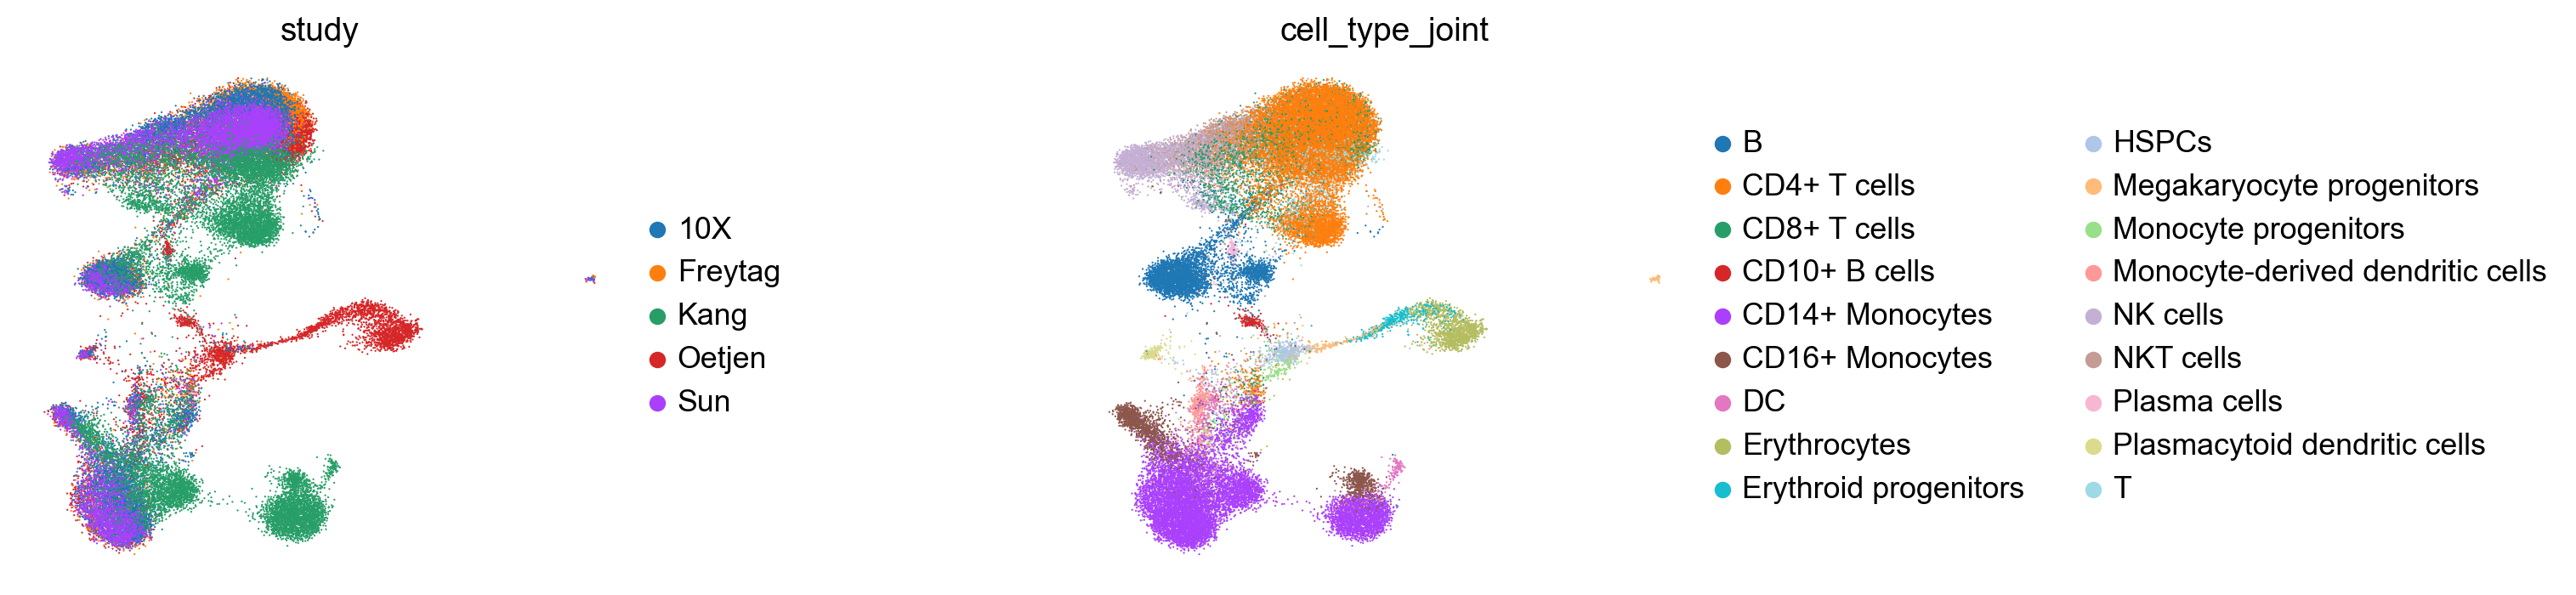

In [11]:
sc.pl.umap(adata, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

In [12]:
scores = diff_exp(adata, 'cell_type_joint', 'study', intr_cvae, n_perm=3000)

In [17]:
for k in scores:
    print(k)
    mask = np.abs(scores[k]['bf'])> 3 # bayes vactor value to filter, can use 2.31 or even lower
    s = sum(mask)
    sort = np.argsort(np.abs(scores[k]['bf'])[mask])[::-1]
    if s > 0:
        print(adata.uns['active_terms'][mask][sort])
    print(s)

B
['MHC_CLASS_II_ANTIGEN_PRESENTAT' 'SIGNALING_BY_THE_B_CELL_RECEPT']
2
CD10+ B cells
['NONSENSE_MEDIATED_DECAY_ENHANC' 'DEVELOPMENTAL_BIOLOGY']
2
CD14+ Monocytes
['ADAPTIVE_IMMUNE_SYSTEM' 'BIOLOGICAL_OXIDATIONS' 'HEMOSTASIS' 'AMYLOIDS']
4
CD16+ Monocytes
0
CD4+ T cells
0
CD8+ T cells
0
DC
0
Erythrocytes
['FACTORS_INVOLVED_IN_MEGAKARYOC']
1
Erythroid progenitors
['LATENT_INFECTION_OF_HOMO_SAPIE' 'ANTIGEN_PROCESSING_CROSS_PRESE'
 'RNA_POL_I_TRANSCRIPTION' 'TRANSLATION' 'CELL_CYCLE_MITOTIC'
 'MUSCLE_CONTRACTION' 'CHROMOSOME_MAINTENANCE']
7
HSPCs
['NONSENSE_MEDIATED_DECAY_ENHANC']
1
Megakaryocyte progenitors
0
Monocyte progenitors
0
Monocyte-derived dendritic cells
0
NK cells
['IMMUNOREGULATORY_INTERACTIONS_']
1
NKT cells
0
Plasma cells
['UNFOLDED_PROTEIN_RESPONSE' 'LATENT_INFECTION_OF_HOMO_SAPIE']
2
Plasmacytoid dendritic cells
['INTERFERON_GAMMA_SIGNALING' 'DEVELOPMENTAL_BIOLOGY'
 'ACTIVATED_TLR4_SIGNALLING' 'NONSENSE_MEDIATED_DECAY_ENHANC'
 'SMOOTH_MUSCLE_CONTRACTION' 'METABOLISM_OF_LI

In [18]:
scores = diff_exp(adata, 'condition_joint', 'study', intr_cvae, n_perm=3000)

In [19]:
adata.uns['active_terms'][np.abs(scores['control']['bf'])> 3]

array(['INTERFERON_ALPHA_BETA_SIGNALIN', 'INTERFERON_SIGNALING'],
      dtype=object)